# An implementation of GPT2 in tinygrad

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": True
}

### Encoding

In [ ]:
import pathlib
import textwrap
import tiktoken

from tinygrad import Tensor, nn


class TinyEncoder:

    def __init__(self):
        self.tokenizer = tiktoken.get_encoding("gpt2")

    def __call__(self, text:str) -> Tensor:
        token_ids = self.tokenizer.encode(text, allowed_special={"<|endoftext|>"})
        token_ids = Tensor(token_ids)
        return token_ids

    def decode(self, idx: Tensor) -> str:
        return self.tokenizer.decode()


In [3]:
import requests as r


response = r.get("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt")
response.raise_for_status()
content = response.text
text = content
pathlib.Path('the-verdict.txt').write_text(content)

20479

In [4]:
Tensor.manual_seed(42)
encoder = TinyEncoder()
embedding = encoder(text)
print(embedding.numpy(), embedding.shape)


[  40  367 2885 ...  286 1242  526] (5145,)


### Multi-head Attention

In [ ]:
import math
from tinygrad import Tensor, nn


class MultiHeadAttention:

    def __init__(self, d_in: int, d_out: int, context_length: int, n_heads: int, dropout: float = 0.0, bias=False) -> None:
        self.d_in = d_in
        self.d_out = d_out
        self.context_length = context_length
        self.n_heads = n_heads
        self.head_dim = self.d_out // n_heads

        assert self.d_out % n_heads == 0

        # Linear Projections
        self.W_q = nn.Linear(d_in, d_out, bias=bias)
        self.W_k = nn.Linear(d_in, d_out, bias=bias)
        self.W_v = nn.Linear(d_in, d_out, bias=bias)

        self.dropout = dropout
        self.out_proj = nn.Linear(d_out, d_out, bias=bias)

        self.k_cache = None
        self.v_cache = None

    def reset_cache(self) -> None:
        self.k_cache = None
        self.v_cache = None


    def __call__(self, x: Tensor, use_cache: bool = False) -> Tensor:
        b, num_tokens, _ = x.shape

        # linear projections (B, num_tokens, d_out)
        keys = self.W_k(x)
        queries = self.W_q(x)
        values = self.W_v(x)

        # split heads (B, num_tokens, d_out) -> (B, n_heads, num_tokens, head_dim)
        keys = keys.reshape(b, num_tokens, self.n_heads, self.head_dim).transpose(1,2)
        queries = queries.reshape(b, num_tokens, self.n_heads, self.head_dim).transpose(1,2)
        values = values.reshape(b, num_tokens, self.n_heads, self.head_dim).transpose(1,2)

        # Causal mask example (chunked input: tokens 3,4,5 with tokens 0-2 cached):
        #          k0   k1   k2   k3   k4   k5
        #    q3 [[ 0.2  0.5  0.1  0.8 -inf -inf ]   ← attends to 0-3
        #    q4  [ 0.1  0.3  0.6  0.2  0.7 -inf ]   ← attends to 0-4
        #    q5  [ 0.4  0.2  0.5  0.3  0.1  0.6 ]]  ← attends to 0-5
        if use_cache:
            if self.k_cache is not None:
                self.k_cache = self.k_cache.cat(keys, dim=2).realize()
                self.v_cache = self.v_cache.cat(values, dim=2).realize()
                keys = self.k_cache
                values = self.v_cache
            else:
                self.k_cache = keys.realize()
                self.v_cache = values.realize()

        attention_scores = queries @ keys.transpose(2,3)

        if use_cache:
            num_tokens_k, num_tokens_q = keys.shape[2], queries.shape[2]
            causal_mask = Tensor.triu(Tensor.ones(num_tokens_q, num_tokens_k), diagonal=num_tokens_k - num_tokens_q + 1).bool()
        else:
            causal_mask = Tensor.triu(Tensor.ones(num_tokens, num_tokens), diagonal=1).bool()

        attention_scores = attention_scores.masked_fill(causal_mask, -math.inf)
        attention_weights = (attention_scores / self.head_dim ** 0.5).softmax(axis=-1)
        attention_weights = attention_weights.dropout(self.dropout)

        context_vec = attention_weights @ values

        # (B, n_heads, num_tokens, head_dim) -> (B, num_tokens, d_out)
        context_vec = context_vec.transpose(1, 2).contiguous().reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec

In [6]:
# Test MHA

inputs = Tensor(
  [[0.43, 0.15, 0.89],
   [0.55, 0.87, 0.66],
   [0.57, 0.85, 0.64],
   [0.22, 0.58, 0.33],
   [0.77, 0.25, 0.10],
   [0.05, 0.80, 0.55]]
)

Tensor.manual_seed(42)
attn = MultiHeadAttention(3, 2, context_length=10, n_heads=2, dropout=0.0)

# Without KV-cache
batch = Tensor.stack([inputs])
print(attn(batch).realize().numpy())

# With KV-cache
for idx in inputs:
    print(attn(Tensor.stack(idx.unsqueeze(0)), use_cache=True).realize().numpy())

attn.reset_cache()


for i in range(0, inputs.shape[0], 3):
    print('---------')
    print(attn(Tensor.stack(inputs[i:i+3],), use_cache=True).numpy())

[[[0.16880184 0.23237522]
  [0.22965987 0.17538859]
  [0.25059026 0.15716936]
  [0.22648945 0.126368  ]
  [0.22968857 0.12661736]
  [0.21490379 0.10757473]]]
[[[0.16880184 0.23237522]]]
[[[0.22965987 0.17538859]]]
[[[0.25059026 0.15716936]]]
[[[0.22648945 0.126368  ]]]
[[[0.22968857 0.12661736]]]
[[[0.21490379 0.10757473]]]
---------
[[[0.16880184 0.23237522]
  [0.22965987 0.17538859]
  [0.25059026 0.15716936]]]
---------
[[[0.22648945 0.126368  ]
  [0.22968857 0.12661736]
  [0.21490379 0.10757473]]]


### Transformer Block

In [7]:
import math
from tinygrad import Tensor


class GELU:

    def __call__(self, x: Tensor) -> Tensor:
        result = x + 0.044715 * x.pow(3)
        result = (2 / math.pi) ** 0.5 * result
        result = 1 + result.tanh()
        result = 0.5 * x * result
        return result


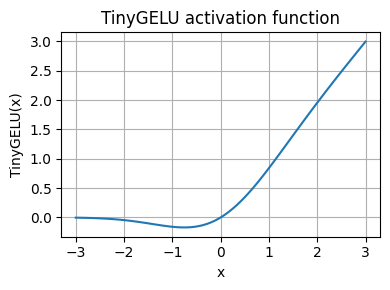

In [8]:
import matplotlib.pyplot as plt

gelu = GELU()

def linspace(start, end, steps):
    return Tensor.arange(steps) * ((end - start) / (steps - 1)) + start

x = linspace(-3, 3, 100)
y_gelu = gelu(x)

plt.figure(figsize=(4, 3))
plt.title(f"TinyGELU activation function")
plt.xlabel("x")
plt.ylabel("TinyGELU(x)")
plt.grid(True)
plt.plot(x.numpy(), y_gelu.numpy())

plt.tight_layout()
plt.show()

In [ ]:
class FeedForward:

    def __init__(self, emb_dim: int):
        self.emb_dim = emb_dim
        self.expansion =  nn.Linear(emb_dim, emb_dim * 4, bias=True)    # Expansion
        self.activation = GELU()                                         # Activation
        self.projection = nn.Linear(4 * emb_dim, emb_dim, bias=True)    # Projection (reduction)

    def __call__(self, x: Tensor) -> Tensor:
        x = self.expansion(x)
        x = self.activation(x)
        x = self.projection(x)
        return x


class LayerNorm:
    def __init__(self, emb_dim: int):
        super().__init__()
        self.eps = 1e-5                                           # Epsilon
        self.scale = Tensor.ones(emb_dim, requires_grad=True)     # Gamma
        self.shift = Tensor.zeros(emb_dim, requires_grad=True)    # Beta

    def __call__(self, x: Tensor) -> Tensor:
        mean = x.mean(axis=-1, keepdim=True)
        var = x.var(axis=-1, keepdim=True,  correction=False)
        norm_x = (x - mean) / (var + self.eps).sqrt()
        return self.scale * norm_x + self.shift


class TransformerBlock:

    def __init__(self, cfg: dict[str, object]):
        super().__init__()

        self.attention = MultiHeadAttention(
            d_in=cfg['emb_dim'],
            d_out=cfg['emb_dim'],
            context_length=cfg['context_length'],
            n_heads=cfg['n_heads'],
            dropout=cfg['drop_rate'],
            bias=cfg['qkv_bias']
        )

        self.ff = FeedForward(cfg['emb_dim'])
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_rate = cfg['drop_rate']  # applied at multiple levels to prevent overfitting at each level


    def __call__(self, x: Tensor, use_cache: bool = False) -> Tensor:
        shortcut = x
        x = self.norm1(x)
        x = self.attention(x, use_cache=use_cache)
        x = x.dropout(self.drop_rate)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = x.dropout(self.drop_rate)
        x = x + shortcut

        return x

In [10]:
block = TransformerBlock(GPT_CONFIG_124M)
x = Tensor.rand(2,5,768)
y = block(x)

print(x.numpy())
print(y.numpy())

[[[0.32425022 0.45340955 0.9434469  ... 0.22476125 0.8282944  0.12121451]
  [0.11831605 0.7358427  0.02549875 ... 0.3609004  0.6774144  0.27182257]
  [0.41263247 0.07596242 0.30133176 ... 0.4330175  0.00716591 0.45269322]
  [0.84338725 0.05184698 0.452672   ... 0.74305844 0.7272855  0.55237985]
  [0.20081961 0.20384157 0.8948964  ... 0.02317965 0.06514275 0.7527548 ]]

 [[0.5678903  0.34231567 0.26108468 ... 0.27493286 0.20989025 0.8912778 ]
  [0.39502013 0.8524592  0.41149628 ... 0.10120249 0.95252466 0.81433797]
  [0.4617046  0.99862456 0.04087234 ... 0.9027206  0.88531184 0.24324119]
  [0.89354396 0.48269737 0.730947   ... 0.311458   0.8983326  0.52540696]
  [0.5904565  0.5662632  0.39956796 ... 0.8285577  0.75530875 0.74672985]]]
[[[ 0.34138134  0.5901247   1.2068514  ...  0.07894972  0.2779263
   -0.283796  ]
  [-0.12481068  0.47510314  0.16681825 ...  0.12757309  0.30945575
   -0.11128822]
  [-0.04308255  0.2587163   0.24907504 ...  0.38529179  0.02040079
    0.47557762]
  [ 0.74

### GPT model

In [11]:
from tinygrad import Tensor, nn

class TinyGPTModel:
    def __init__(self, cfg: dict[str, object]):

        # Embedding
        self.emb_layer = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_layer = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_rate = cfg["drop_rate"]

        # Transformer blocks
        self.trf_blocks = [TransformerBlock(cfg) for _ in range(cfg["n_layers"])]

        # Layer norms
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=True)

        self.current_pos = 0


    def __call__(self, in_idx: Tensor, use_cache: bool = False) -> Tensor:
        num_batches, seq_len = in_idx.shape
        embedding = self.emb_layer(in_idx)

        if use_cache:
            positions = Tensor.arange(self.current_pos, self.current_pos + seq_len)
            self.current_pos += seq_len
        else:
            positions = Tensor.arange(seq_len)
            self.current_pos = seq_len

        pos_embeddings = self.pos_layer(positions)

        x = embedding + pos_embeddings
        x = x.dropout(self.drop_rate)
        for block in self.trf_blocks:
            x = block(x, use_cache=use_cache)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

    def reset_cache(self) -> None:
        self.current_pos = 0
        for blk in self.trf_blocks:
            blk.attention.reset_cache()

Tensor.manual_seed(42)
tiny = TinyGPTModel(GPT_CONFIG_124M)
input_batch = encoder("Hello, how are you?").unsqueeze(0)
logits = tiny(input_batch)

print(logits.numpy(), logits.shape)

[[[-0.37475854  0.91921234  0.377479   ...  0.19478574  0.04634326
   -0.5028892 ]
  [-0.11838737  0.26292318  0.5065671  ... -0.10617074  0.45981625
   -0.9972051 ]
  [-0.09512917  0.26536468  0.66464454 ... -0.1491879   0.2909158
   -0.98623925]
  [-0.02449884  0.10951907  0.6436204  ... -0.24726972  0.35728818
   -0.81317544]
  [ 0.06015152  0.05567765  0.7080676  ... -0.3271778   0.30426148
   -0.94280696]
  [-0.03009875  0.07611722  0.83187443 ... -0.3352958   0.45460936
   -0.6862832 ]]] (1, 6, 50257)


In [12]:
# count parameters

from tinygrad.nn.state import get_parameters

total_params = sum(p.numel() for p in get_parameters(tiny))
print(f"Total parameters: {total_params:,}")

total_params_gpt2 = total_params - get_parameters(tiny.out_head)[0].numel()
print(f"Total parameters considering weight tying: {total_params_gpt2:,}")  # Should be ~124M

# Exercise 4.1
# Calculate the number of params of the feed forward module and the multi head attention module
ff_params = 0
for p in get_parameters(tiny.trf_blocks[0].ff):
    ff_params += p.numel()
print(f'Each feed forward module has {ff_params:,} parameters, which is in sum {12*ff_params:,}.')

attn_params = 0
for p in get_parameters(tiny.trf_blocks[0].attention):
    attn_params += p.numel()
print(f'Each attention module has {attn_params:,} parameters, which is in sum {12*attn_params:,}.')


Total parameters: 163,138,722
Total parameters considering weight tying: 124,541,346
Each feed forward module has 4,722,432 parameters, which is in sum 56,669,184.
Each attention module has 2,362,368 parameters, which is in sum 28,348,416.


In [ ]:
# Download GPT2 weights
import pathlib
import requests as r

BASE_URL = "https://openaipublic.blob.core.windows.net/gpt-2/models"
FILES = [
    "checkpoint", "encoder.json", "hparams.json",
    "model.ckpt.data-00000-of-00001", "model.ckpt.index",
    "model.ckpt.meta", "vocab.bpe"
]
MODEL_SIZE = "124M"
MODELS_DIR = "gpt2_weights"

models_dir = pathlib.Path(MODELS_DIR)
models_dir.mkdir(exist_ok=True)

for filename in FILES:
        url = f"{BASE_URL}/{MODEL_SIZE}/{filename}"
        filepath = models_dir.joinpath(filename)
        if not filepath.exists():
            print(f"Downloading {filename}...")
            response = r.get(url)
            with open(filepath, "wb") as f:
                f.write(response.content)


In [14]:
# Load tensorflow checkpoint
import tensorflow as tf

tf_ckpt_path = models_dir.joinpath("model.ckpt")
params = {}

for name, _ in tf.train.list_variables(tf_ckpt_path):
    arr = tf.train.load_variable(tf_ckpt_path, name)
    params[name] = arr

In [15]:
import numpy as np

def to_tensor(arr: np.array) -> Tensor:
    return Tensor(arr.astype(np.float32))

def assign(left: Tensor, right: Tensor):
    if left.shape != right.shape:
        raise ValueError(f'Dimensions mismatch: {left.shape} != {right.shape}')
    return right

In [ ]:
tiny_model = TinyGPTModel(GPT_CONFIG_124M)

tiny_model.emb_layer.weight = assign(tiny_model.emb_layer.weight, to_tensor(params["model/wte"]))
tiny_model.pos_layer.weight = assign(tiny_model.pos_layer.weight, to_tensor(params["model/wpe"]))

for i, block in enumerate(tiny_model.trf_blocks):
    # Layer norms
    block.norm1.scale = assign(block.norm1.scale, to_tensor(params[f"model/h{i}/ln_1/g"]))
    block.norm1.shift = assign(block.norm1.shift, to_tensor(params[f"model/h{i}/ln_1/b"]))
    block.norm2.scale = assign(block.norm2.scale, to_tensor(params[f"model/h{i}/ln_2/g"]))
    block.norm2.shift = assign(block.norm2.shift, to_tensor(params[f"model/h{i}/ln_2/b"]))

    # Attention - weights
    qkv_w = params[f"model/h{i}/attn/c_attn/w"][0]  # Shape: (768, 2304)
    q_w, k_w, v_w = np.split(qkv_w, 3, axis=-1)

    block.attention.W_q.weight = assign(block.attention.W_q.weight, to_tensor(q_w.T))
    block.attention.W_k.weight = assign(block.attention.W_k.weight, to_tensor(k_w.T))
    block.attention.W_v.weight = assign(block.attention.W_v.weight, to_tensor(v_w.T))

    # Attention - bias
    qkv_b = params[f"model/h{i}/attn/c_attn/b"]
    q_b, k_b, v_b = np.split(qkv_b, 3, axis=-1)

    block.attention.W_q.bias = assign(block.attention.W_q.bias, to_tensor(q_b))
    block.attention.W_k.bias = assign(block.attention.W_k.bias, to_tensor(k_b))
    block.attention.W_v.bias = assign(block.attention.W_v.bias, to_tensor(v_b))

    # Attention = Output projection
    block.attention.out_proj.weight = assign(block.attention.out_proj.weight, to_tensor(params[f"model/h{i}/attn/c_proj/w"][0].T))
    block.attention.out_proj.bias = assign(block.attention.out_proj.bias, to_tensor(params[f"model/h{i}/attn/c_proj/b"]))

    # FFN
    block.ff.expansion.weight = assign(block.ff.expansion.weight, to_tensor(params[f"model/h{i}/mlp/c_fc/w"][0].T))
    block.ff.expansion.bias = assign(block.ff.expansion.bias, to_tensor(params[f"model/h{i}/mlp/c_fc/b"]))
    block.ff.projection.weight = assign(block.ff.projection.weight, to_tensor(params[f"model/h{i}/mlp/c_proj/w"][0].T))
    block.ff.projection.bias = assign(block.ff.projection.bias, to_tensor(params[f"model/h{i}/mlp/c_proj/b"]))


# Final norm
tiny_model.final_norm.scale = to_tensor(params["model/ln_f/g"])
tiny_model.final_norm.shift = to_tensor(params["model/ln_f/b"])

# Output head
tiny_model.out_head.weight = to_tensor(params["model/wte"])

In [ ]:
import time

from IPython.display import display, HTML, clear_output

input_batch = encoder("What is the purpose of life?").unsqueeze(0)
logits = tiny_model(input_batch)

max_new_tokens = 15
idx = input_batch
context_size = 1024
start = time.time()

for _ in range(max_new_tokens):
    # Limit the current context
    idx_cond = idx[:, -context_size:]

    # Calculate predictions from the last token.
    # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
    logits = tiny_model(idx_cond)
    logits = logits[:, -1, :]

    # Chose the highest probability value
    probas = logits.softmax(axis=-1)
    nxt = probas.argmax(axis=-1, keepdim=True)

    # Append the predicted token to the current sequence
    idx = idx.cat(nxt, dim=1)
    #print(idx.numpy())

    output = encoder.tokenizer.decode(idx.squeeze(0).tolist())
    clear_output(wait=True)
    print(output, end="", flush=True)

print(f'Generated {max_new_tokens} tokens in {time.time() - start: .1f}s')

What is the purpose of life?

The purpose of life is to live.

The purpose ofGenerated 15 tokens in  60.4s


In [ ]:
import time
from IPython.display import display, HTML, clear_output

input_batch = encoder("What is the purpose of life?").unsqueeze(0)
tiny_model.reset_cache()
logits = tiny_model(input_batch, use_cache=True)

max_new_tokens = 15
idx = input_batch
last_line_count = 0
start = time.time()

for _ in range(max_new_tokens):
    logits = logits[:, -1, :]
    probas = logits.softmax(axis=-1)
    nxt = probas.argmax(axis=-1, keepdim=True).realize()  # force realization to prevent tinygrad from optimizing the compute graph

    idx = idx.cat(nxt, dim=1)

    logits = tiny_model(nxt, use_cache=True).realize()

    output = encoder.tokenizer.decode(idx.squeeze(0).tolist())

    clear_output(wait=True)
    print(output, end="", flush=True)

print(f'Generated {max_new_tokens} tokens in {time.time() - start: .1f}s')

What is the purpose of life?

The purpose of life is to live.

The purpose ofGenerated 15 tokens in  31.7s
